In [1]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


In [2]:
data = pd.read_csv('Data/historical_BTCUSDT_3min_data.csv')

In [3]:
data

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...
632636,1712879280000,70079.02,70084.00,70052.00,70084.00,25.261840,1712879459999,1.770023e+06,1312,12.058600,8.448591e+05,0
632637,1712879460000,70084.00,70105.80,70072.01,70105.80,18.877340,1712879639999,1.322997e+06,1219,9.535250,6.682760e+05,0
632638,1712879640000,70105.80,70135.55,70072.81,70072.82,21.766370,1712879819999,1.525950e+06,1427,10.334630,7.245631e+05,0
632639,1712879820000,70072.81,70072.82,70006.21,70006.23,13.449420,1712879999999,9.418671e+05,983,1.347570,9.437439e+04,0


In [4]:
# Convert ISO 8601 date strings to Unix timestamp (milliseconds)
from datetime import datetime 
def iso_to_unix(iso_str):
    dt = datetime.strptime(iso_str, "%Y-%m-%dT%H:%M:%SZ").replace(tzinfo=timezone.utc)
    return int(dt.timestamp() * 1000)  # Convert to milliseconds

def unix_to_iso(unix_timestamp_ms):
    # Convert milliseconds to seconds
    unix_timestamp_s = unix_timestamp_ms / 1000
    # Create a datetime object from the Unix timestamp
    dt = datetime.utcfromtimestamp(unix_timestamp_s)
    # Format the datetime object as an ISO 8601 date string
    iso_str = dt.strftime("%Y-%m-%dT%H:%M:%SZ")
    return iso_str

In [5]:
data[997:1004]['Open time'].apply(lambda x: unix_to_iso(x))

/tmp/ipykernel_33398/214518976.py:11: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  dt = datetime.utcfromtimestamp(unix_timestamp_s)


997     2020-09-03T01:51:00Z
998     2020-09-03T01:54:00Z
999     2020-09-03T01:57:00Z
1000    2020-09-03T02:00:00Z
1001    2020-09-03T02:03:00Z
1002    2020-09-03T02:06:00Z
1003    2020-09-03T02:09:00Z
Name: Open time, dtype: object

In [6]:
def find_threshold_crossing(df, start_index, percent):
    # Ensure the start_index is valid
    if start_index >= len(df):
        return None, None

    # Getting the open price at the start index
    open_price = df.loc[start_index, 'Open']

    # Calculating the thresholds
    threshold_up = open_price * (1 + percent/100)
    threshold_down = open_price * (1 - percent/100)

    # Variables to store the number of candles it took to cross each threshold
    up_cross = None
    down_cross = None

    # Calculate the maximum number of candles for 7 days
    max_candles = 7 * 24 * 20

    # Iterate through the dataframe starting from the start index
    for index, row in df.loc[start_index:].iterrows():
        if index - start_index > max_candles:
            # Stop if 7 days have passed without crossing either threshold
            break

        if up_cross is None and row['High'] >= threshold_up:
            up_cross = index - start_index

        if down_cross is None and row['Low'] <= threshold_down:
            down_cross = index - start_index

    return up_cross, down_cross

In [7]:
df = data
start_index = 0
result = find_threshold_crossing(df=df, start_index=0, percent=1)
print(result)

(118, 7)


## go to 02-1 threshold_data_gen.py and come back


In [8]:
threshold_data = pd.read_csv('Data/up_down_cross_3min_data.csv')

In [9]:
threshold_data = threshold_data[:len(data)]

In [10]:
print(len(threshold_data))

632641


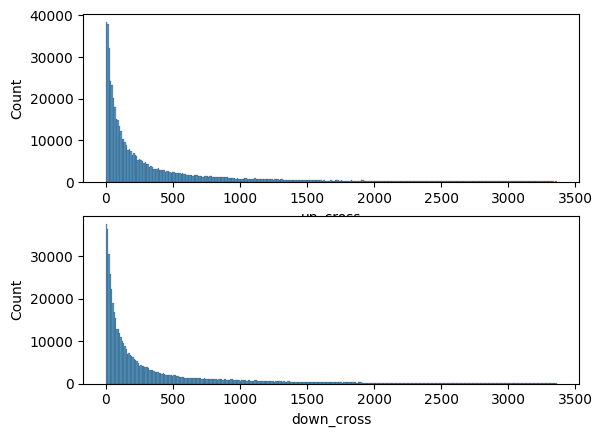

In [11]:
plt.subplot(2,1,1)
sns.histplot(threshold_data['up_cross'])

plt.subplot(2,1,2)
sns.histplot(threshold_data['down_cross'])

plt.show()

In [12]:
threshold_data.isna().sum()/len(threshold_data)*100

up_cross      10.566814
down_cross    13.477944
dtype: float64

In [13]:
temp = threshold_data.fillna(3360)

In [14]:
# Create the 'minutes' column
temp['minutes'] = temp[['up_cross', 'down_cross']].min(axis=1)*3

# Create the 'side' column
temp['side'] = temp.apply(lambda row: 1 if row['up_cross'] < row['down_cross'] else (-1 if row['up_cross'] > row['down_cross'] else 0), axis=1)

# Creating a new DataFrame with just the 'minutes' and 'side' columns
one_percent_data = temp[['minutes', 'side']]


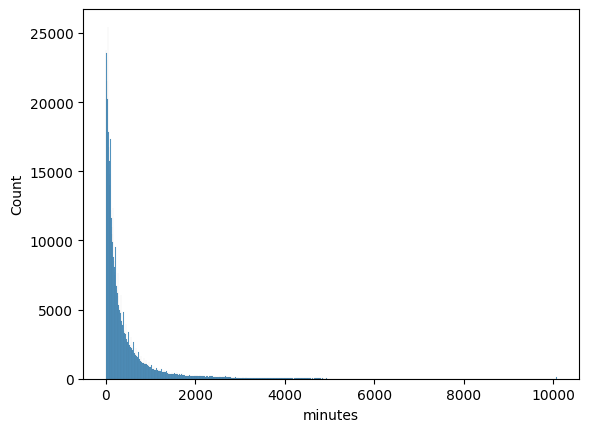

In [15]:
sns.histplot(one_percent_data['minutes'])
plt.show()

In [16]:
one_percent_data['minutes'].describe()

count    632641.000000
mean        422.446743
std         671.384483
min           0.000000
25%          69.000000
50%         189.000000
75%         477.000000
max       10080.000000
Name: minutes, dtype: float64

In [17]:
mean = one_percent_data['minutes'].mean()
median = one_percent_data['minutes'].median()
std_dev = one_percent_data['minutes'].std()
quartiles = one_percent_data['minutes'].quantile([0.25, 0.5, 0.75])

print(f"Mean: {mean}")
print(f"Median: {median}")
print(f"Standard Deviation: {std_dev}")
print(f"1st Quartile: {quartiles[0.25]}")
print(f"2nd Quartile (Median): {quartiles[0.5]}")
print(f"3rd Quartile: {quartiles[0.75]}")

Mean: 422.44674309758614
Median: 189.0
Standard Deviation: 671.3844832968787
1st Quartile: 69.0
2nd Quartile (Median): 189.0
3rd Quartile: 477.0


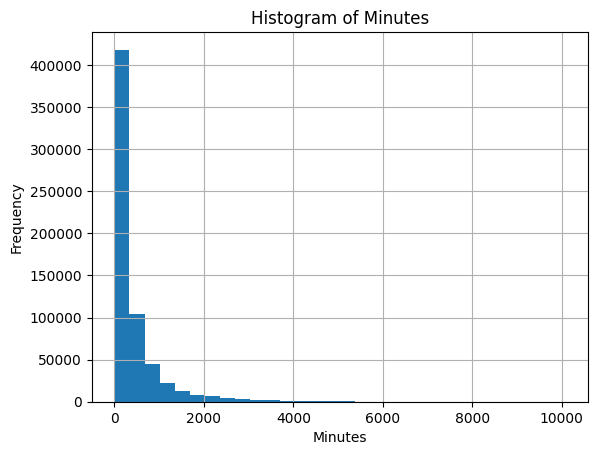

'\n# Q-Q plot\nstats.probplot(one_percent_data[\'minutes\'], dist="norm", plot=plt)\nplt.title(\'Q-Q Plot\')\nplt.show()\n'

In [18]:
# Histogram
one_percent_data['minutes'].hist(bins=30)
plt.title('Histogram of Minutes')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

'''
# Q-Q plot
stats.probplot(one_percent_data['minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()
'''

/tmp/ipykernel_33398/1886537575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_percent_data['log_minutes'] = np.log(one_percent_data['minutes'] + 1)  # Adding 1 to avoid log(0)


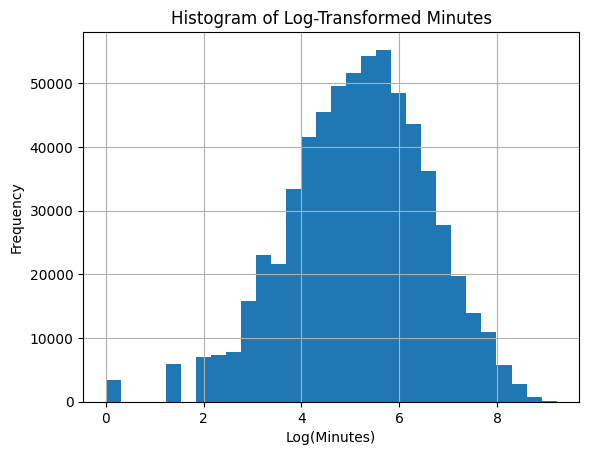

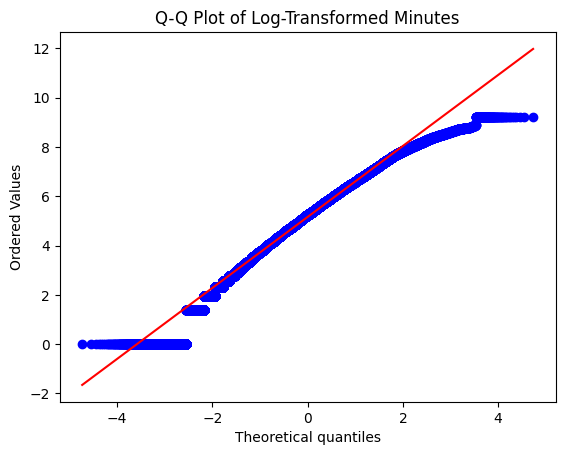

In [19]:
# Log Transformation
one_percent_data['log_minutes'] = np.log(one_percent_data['minutes'] + 1)  # Adding 1 to avoid log(0)

# Now, plot the histogram and Q-Q plot for the transformed data
one_percent_data['log_minutes'].hist(bins=30)
plt.title('Histogram of Log-Transformed Minutes')
plt.xlabel('Log(Minutes)')
plt.ylabel('Frequency')
plt.show()

stats.probplot(one_percent_data['log_minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Minutes')
plt.show()

In [20]:
# remove the outliers
total_length = len(one_percent_data)
side_zeros = len(one_percent_data[one_percent_data['side']==0])
print(f'side = 0 values : {side_zeros/total_length*100}%\n')
more_than_a_day = one_percent_data[one_percent_data['minutes']>24*60]
print(f'took more than a day values : {len(more_than_a_day)/total_length*100}%')
more_than_12hours = one_percent_data[one_percent_data['minutes']>12*60]
print(f'took more than 12 hours values : {len(more_than_12hours)/total_length*100}%')
more_than_8hours = one_percent_data[one_percent_data['minutes']>8*60]
print(f'took more than 8 hours values : {len(more_than_8hours)/total_length*100}%')
more_than_6hours = one_percent_data[one_percent_data['minutes']>6*60]
print(f'took more than 6 hours values : {len(more_than_6hours)/total_length*100}%')
more_than_4hours = one_percent_data[one_percent_data['minutes']>4*60]
print(f'took more than 4 hours values : {len(more_than_4hours)/total_length*100}%')
more_than_3hours = one_percent_data[one_percent_data['minutes']>3*60]
print(f'took more than 3 hours values : {len(more_than_3hours)/total_length*100}%')
more_than_2half_hours = one_percent_data[one_percent_data['minutes']>2.5*60]
print(f'took more than 2.5 hours values : {len(more_than_2half_hours)/total_length*100}%')
more_than_2hours = one_percent_data[one_percent_data['minutes']>2*60]
print(f'took more than 2 hours values : {len(more_than_2hours)/total_length*100}%')

print('')

less_than_15minutes = one_percent_data[one_percent_data['minutes']<15]
print(f'took less than 15 minutes values : {len(less_than_15minutes)/total_length*100}%')
less_than_30minutes = one_percent_data[one_percent_data['minutes']<30]
print(f'took less than 30 minutes values : {len(less_than_30minutes)/total_length*100}%')
less_than_45minutes = one_percent_data[one_percent_data['minutes']<45]
print(f'took less than 45 minutes values : {len(less_than_45minutes)/total_length*100}%')
less_than_1hours = one_percent_data[one_percent_data['minutes']<60]
print(f'took less than 1 hour values : {len(less_than_1hours)/total_length*100}%')
less_than_1half_hours = one_percent_data[one_percent_data['minutes']<90]
print(f'took less than 1.5 hour values : {len(less_than_1half_hours)/total_length*100}%')

side = 0 values : 0.15095449077754997%

took more than a day values : 6.304681486024459%
took more than 12 hours values : 16.04480266059266%
took more than 8 hours values : 24.777085266367497%
took more than 6 hours values : 31.840016691931126%
took more than 4 hours values : 42.951689820925296%
took more than 3 hours values : 50.92177079892072%
took more than 2.5 hours values : 55.830557930959266%
took more than 2 hours values : 61.6875921731282%

took less than 15 minutes values : 4.991140314965359%
took less than 30 minutes values : 11.1232120586557%
took less than 45 minutes values : 16.678495386799145%
took less than 1 hour values : 21.74914366915834%
took less than 1.5 hour values : 30.509088092614927%


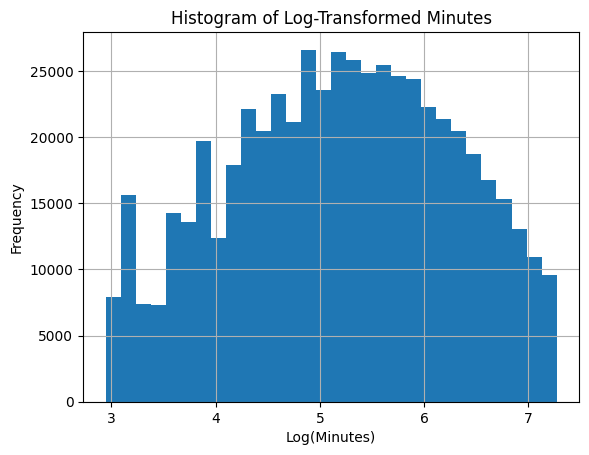

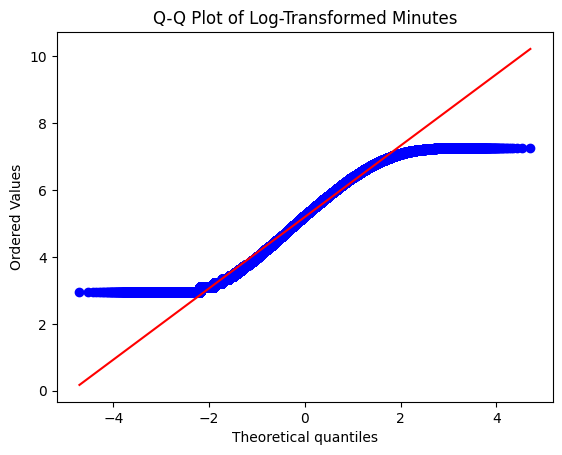

In [21]:
middle_values = one_percent_data[(one_percent_data['minutes']<24*60)&(one_percent_data['minutes']>15)]

# Now, plot the histogram and Q-Q plot for the transformed data
middle_values['log_minutes'].hist(bins=30)
plt.title('Histogram of Log-Transformed Minutes')
plt.xlabel('Log(Minutes)')
plt.ylabel('Frequency')
plt.show()

stats.probplot(middle_values['log_minutes'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Minutes')
plt.show()

In [22]:
np.e**2

7.3890560989306495

In [23]:
np.e**7

1096.6331584284583

In [24]:
less_than_3hours = one_percent_data[one_percent_data['minutes']<3*60]

less_than_3hours

,minutes,side,log_minutes
0,21.0,-1,3.091042
1,18.0,-1,2.944439
2,15.0,-1,2.772589
3,12.0,-1,2.564949
4,9.0,-1,2.302585
...,...,...,...
632573,165.0,-1,5.111988
632574,162.0,-1,5.093750
632575,159.0,-1,5.075174
632576,156.0,-1,5.056246


In [25]:
print(f'up cross : {len(less_than_3hours[less_than_3hours['side']>0])/total_length}')
print(f'down cross : {len(less_than_3hours[less_than_3hours['side']<0])/total_length}')

up cross : 0.2387973590077153
down cross : 0.24706429080631828


In [26]:
temp2 = one_percent_data.copy()
temp2['plus_6'] = ((temp2['minutes']<3*60)&(temp2['side']>0)).astype(int)
temp2['minus_6'] = ((temp2['minutes']<3*60)&(temp2['side']<0)).astype(int)
temp2['zero_6'] = ((temp2['minutes']>=3*60)|(temp2['side']==0)).astype(int)
data2 = temp2

In [27]:
df_all = pd.concat([data,threshold_data,data2],axis=1)

df_all

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,up_cross,down_cross,minutes,side,log_minutes,plus_6,minus_6,zero_6
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0,118.0,7.0,21.0,-1,3.091042,0,1,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0,117.0,6.0,18.0,-1,2.944439,0,1,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0,116.0,5.0,15.0,-1,2.772589,0,1,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0,115.0,4.0,12.0,-1,2.564949,0,1,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0,114.0,3.0,9.0,-1,2.302585,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632636,1712879280000,70079.02,70084.00,70052.00,70084.00,25.261840,1712879459999,1.770023e+06,1312,12.058600,8.448591e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632637,1712879460000,70084.00,70105.80,70072.01,70105.80,18.877340,1712879639999,1.322997e+06,1219,9.535250,6.682760e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632638,1712879640000,70105.80,70135.55,70072.81,70072.82,21.766370,1712879819999,1.525950e+06,1427,10.334630,7.245631e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632639,1712879820000,70072.81,70072.82,70006.21,70006.23,13.449420,1712879999999,9.418671e+05,983,1.347570,9.437439e+04,0,NaN,NaN,10080.0,0,9.218408,0,0,1


In [28]:
# Create a boolean series where True indicates the rows with the sum equal to 1
rows_with_sum_one = (df_all['plus_6'] + df_all['minus_6'] + df_all['zero_6']) == 1

# Check if all values in the boolean series are True
all_rows_sum_to_one = rows_with_sum_one.all()

print(f"All rows have a sum of 1: {all_rows_sum_to_one}")


All rows have a sum of 1: True


In [29]:
df_all.to_csv('Data/df_all.csv', index=False)

In [30]:
temp3 = pd.read_csv('Data/df_all.csv')
temp3

,Open time,Open,High,Low,Close,Volume,Close time,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,Ignore,up_cross,down_cross,minutes,side,log_minutes,plus_6,minus_6,zero_6
0,1598918400000,11649.51,11668.50,11649.50,11667.12,165.713325,1598918579999,1.932464e+06,2146,83.409576,9.725705e+05,0,118.0,7.0,21.0,-1,3.091042,0,1,0
1,1598918580000,11667.12,11667.72,11634.06,11645.19,248.783097,1598918759999,2.897763e+06,3230,92.608664,1.078562e+06,0,117.0,6.0,18.0,-1,2.944439,0,1,0
2,1598918760000,11645.51,11649.88,11629.00,11639.12,217.735241,1598918939999,2.534315e+06,5186,93.190672,1.084609e+06,0,116.0,5.0,15.0,-1,2.772589,0,1,0
3,1598918940000,11639.12,11642.21,11630.21,11639.01,169.768550,1598919119999,1.975641e+06,3282,56.131767,6.532171e+05,0,115.0,4.0,12.0,-1,2.564949,0,1,0
4,1598919120000,11639.00,11640.01,11627.22,11634.16,130.973394,1598919299999,1.523519e+06,2300,45.500733,5.292799e+05,0,114.0,3.0,9.0,-1,2.302585,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632636,1712879280000,70079.02,70084.00,70052.00,70084.00,25.261840,1712879459999,1.770023e+06,1312,12.058600,8.448591e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632637,1712879460000,70084.00,70105.80,70072.01,70105.80,18.877340,1712879639999,1.322997e+06,1219,9.535250,6.682760e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632638,1712879640000,70105.80,70135.55,70072.81,70072.82,21.766370,1712879819999,1.525950e+06,1427,10.334630,7.245631e+05,0,NaN,NaN,10080.0,0,9.218408,0,0,1
632639,1712879820000,70072.81,70072.82,70006.21,70006.23,13.449420,1712879999999,9.418671e+05,983,1.347570,9.437439e+04,0,NaN,NaN,10080.0,0,9.218408,0,0,1
